<a href="https://colab.research.google.com/github/TioSatrio100/LSTM-ADHD/blob/main/LSTM_ADHD2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
import numpy as np
import pandas as pd
from scipy import signal
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Flatten, Dense
from tensorflow.keras.models import Model

# **Data Preparation & EDA**

In [22]:
# Load data
dt = pd.read_csv("adhd2.csv")

In [23]:
dt.head()

,Fp1,Fp2,F3,F4,C3,C4,P3,P4,O1,O2,F7,F8,T7,T8,P7,P8,Fz,Cz,Pz,class
0,85.0,261.0,52.0,226.0,52.0,200.0,126.0,310.0,-20.0,236.0,126.0,200.0,-20.0,200.0,-20.0,347.0,85.0,50.0,85.0,0
1,156.0,508.0,126.0,226.0,126.0,236.0,89.0,310.0,-57.0,273.0,273.0,420.0,16.0,310.0,-57.0,89.0,297.0,121.0,85.0,0
2,297.0,473.0,89.0,332.0,52.0,163.0,-167.0,236.0,-20.0,126.0,236.0,273.0,-57.0,126.0,-167.0,273.0,402.0,15.0,-160.0,0
3,191.0,402.0,89.0,156.0,89.0,89.0,-94.0,163.0,-167.0,200.0,89.0,200.0,-57.0,52.0,-167.0,89.0,85.0,156.0,-90.0,0
4,156.0,402.0,89.0,121.0,52.0,126.0,-131.0,89.0,16.0,89.0,126.0,200.0,-20.0,52.0,-131.0,52.0,332.0,121.0,-55.0,0


In [24]:
dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1918628 entries, 0 to 1918627
Data columns (total 20 columns):
 #   Column  Dtype  
---  ------  -----  
 0   Fp1     float64
 1   Fp2     float64
 2   F3      float64
 3   F4      float64
 4   C3      float64
 5   C4      float64
 6   P3      float64
 7   P4      float64
 8   O1      float64
 9   O2      float64
 10  F7      float64
 11  F8      float64
 12  T7      float64
 13  T8      float64
 14  P7      float64
 15  P8      float64
 16  Fz      float64
 17  Cz      float64
 18  Pz      float64
 19  class   int64  
dtypes: float64(19), int64(1)
memory usage: 292.8 MB


In [25]:
top_2000 = dt.head(2000)


In [26]:
bottom_2000 = dt.tail(2000)


In [27]:
df = pd.concat([top_2000, bottom_2000], ignore_index=True)
df

,Fp1,Fp2,F3,F4,C3,C4,P3,P4,O1,O2,F7,F8,T7,T8,P7,P8,Fz,Cz,Pz,class
0,85.0,261.0,52.0,226.0,52.0,200.0,126.0,310.0,-20.0,236.0,126.0,200.0,-20.0,200.0,-20.0,347.0,85.0,50.0,85.0,0
1,156.0,508.0,126.0,226.0,126.0,236.0,89.0,310.0,-57.0,273.0,273.0,420.0,16.0,310.0,-57.0,89.0,297.0,121.0,85.0,0
2,297.0,473.0,89.0,332.0,52.0,163.0,-167.0,236.0,-20.0,126.0,236.0,273.0,-57.0,126.0,-167.0,273.0,402.0,15.0,-160.0,0
3,191.0,402.0,89.0,156.0,89.0,89.0,-94.0,163.0,-167.0,200.0,89.0,200.0,-57.0,52.0,-167.0,89.0,85.0,156.0,-90.0,0
4,156.0,402.0,89.0,121.0,52.0,126.0,-131.0,89.0,16.0,89.0,126.0,200.0,-20.0,52.0,-131.0,52.0,332.0,121.0,-55.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,50.0,85.0,52.0,50.0,52.0,52.0,52.0,16.0,16.0,52.0,126.0,126.0,126.0,126.0,163.0,89.0,50.0,-19.0,50.0,1
3996,121.0,85.0,126.0,15.0,126.0,16.0,52.0,16.0,-20.0,16.0,163.0,89.0,163.0,16.0,126.0,-20.0,50.0,-55.0,50.0,1
3997,15.0,-55.0,52.0,-90.0,89.0,-57.0,89.0,-20.0,200.0,16.0,89.0,16.0,126.0,-20.0,52.0,-20.0,-19.0,-19.0,85.0,1
3998,85.0,121.0,126.0,50.0,200.0,52.0,163.0,52.0,163.0,163.0,163.0,89.0,200.0,126.0,163.0,163.0,85.0,121.0,121.0,1


In [28]:
# Checking for missing values
for col in df.columns:
    if(df[col].isnull().sum()>0):
        print(col)

Classes are almost balanced. We can get away with the difference.
class
0    2000
1    2000
Name: count, dtype: int64


<Axes: title={'center': 'Label'}, xlabel='class'>

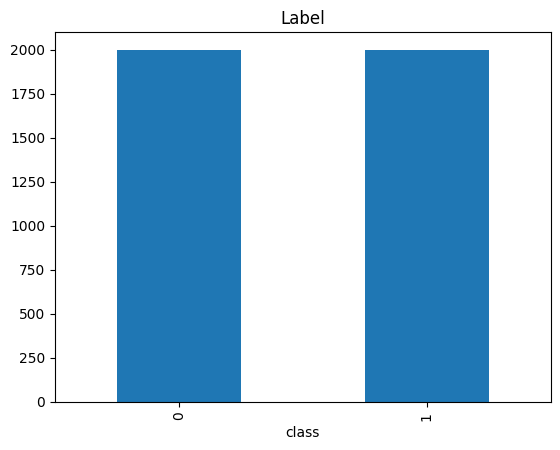

In [29]:
print(f"Classes are almost balanced. We can get away with the difference.\n{df['class'].value_counts()}")
df['class'].value_counts().plot(kind='bar', color='tab:blue', title='Label')

# **Data Signal Visualization**

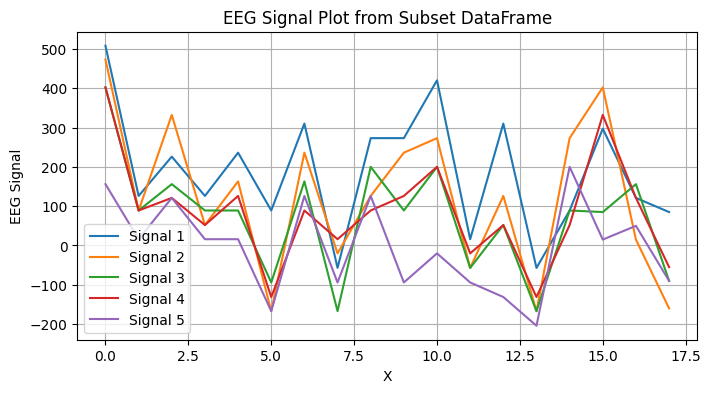

In [30]:
# Memilih 5 sampel sinyal EEG untuk plot dari subset DataFrame
sample_signal_1 = df.iloc[1, 1:-1].values
sample_signal_2 = df.iloc[2, 1:-1].values
sample_signal_3 = df.iloc[3, 1:-1].values
sample_signal_4 = df.iloc[4, 1:-1].values
sample_signal_5 = df.iloc[5, 1:-1].values

# Menghasilkan sumbu waktu berdasarkan jumlah data poin
time_axis = np.arange(0, len(sample_signal_1), 1)

# Menghitung waktu berdasarkan durasi tiap data poin
sampling_rate = 1  # Ubah dengan frekuensi sampling yang sesuai
time = time_axis / sampling_rate

# Membuat plot sinyal EEG dari subset DataFrame
plt.figure(figsize=(8, 4))
plt.plot(time, sample_signal_1, label='Signal 1')
plt.plot(time, sample_signal_2, label='Signal 2')
plt.plot(time, sample_signal_3, label='Signal 3')
plt.plot(time, sample_signal_4, label='Signal 4')
plt.plot(time, sample_signal_5, label='Signal 5')
plt.xlabel('X')
plt.ylabel('EEG Signal')
plt.title('EEG Signal Plot from Subset DataFrame')
plt.legend()
plt.grid(True)
plt.show()



# **Data Modelling**

In [31]:
Y = df['class'].copy()
X = df.drop('class', axis=1).copy()

X_train, x_test, Y_train, y_test = train_test_split(X, Y,random_state=111, test_size=0.3)
X_train, x_val, Y_train, y_val=train_test_split(X_train, Y_train, random_state=111, test_size=0.3)

In [32]:

model = Sequential([
    Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.5),  # Dropout dengan tingkat dropout 0.5 (50%)
    Dense(256, activation='relu'),
    Dropout(0.3),  # Dropout dengan tingkat dropout 0.3 (30%)
    Dense(1, activation='sigmoid')  # untuk klasifikasi biner
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [33]:
history = model.fit(X_train, Y_train,
                         batch_size=64,
                         epochs=10,
                         validation_split=0.2)

Epoch 1/10
25/25 [==============================] - 1s 15ms/step - loss: 22.1957 - accuracy: 0.6231 - val_loss: 7.4637 - val_accuracy: 0.7219
Epoch 2/10
25/25 [==============================] - 0s 6ms/step - loss: 7.3673 - accuracy: 0.7398 - val_loss: 1.2724 - val_accuracy: 0.8546
Epoch 3/10
25/25 [==============================] - 0s 7ms/step - loss: 4.2352 - accuracy: 0.7577 - val_loss: 1.5993 - val_accuracy: 0.8495
Epoch 4/10
25/25 [==============================] - 0s 6ms/step - loss: 3.1889 - accuracy: 0.7838 - val_loss: 0.9709 - val_accuracy: 0.8801
Epoch 5/10
25/25 [==============================] - 0s 6ms/step - loss: 2.7530 - accuracy: 0.8017 - val_loss: 0.5494 - val_accuracy: 0.8827
Epoch 6/10
25/25 [==============================] - 0s 8ms/step - loss: 2.0994 - accuracy: 0.7895 - val_loss: 0.3125 - val_accuracy: 0.9082
Epoch 7/10
25/25 [==============================] - 0s 6ms/step - loss: 1.7033 - accuracy: 0.8189 - val_loss: 0.5199 - val_accuracy: 0.8929
Epoch 8/10
25/25 [

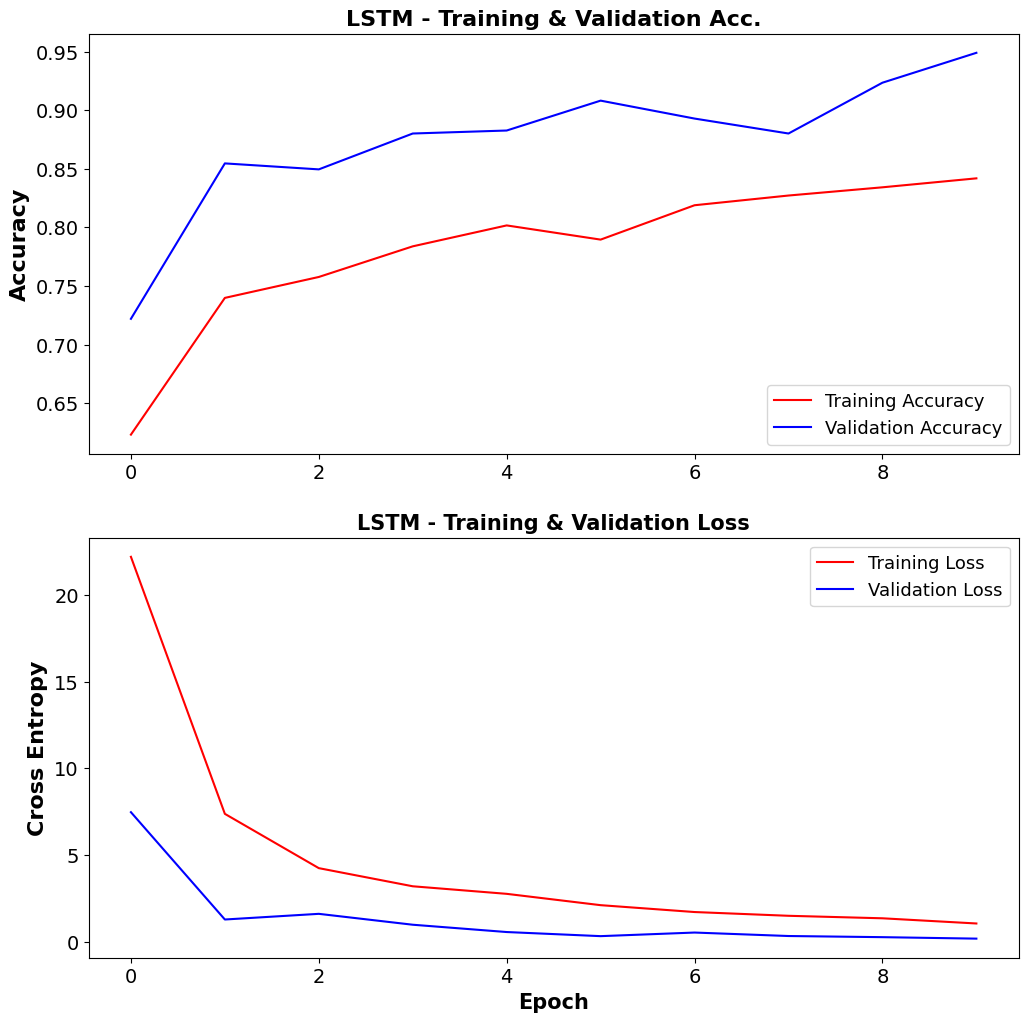

In [36]:
acc =history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss =history.history['val_loss']


plt.figure(figsize=(12, 12))

plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy', color='r')
plt.plot(val_acc, label='Validation Accuracy', color='b')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='lower right', fontsize=13)
plt.ylabel('Accuracy', fontsize=16, weight='bold')
plt.title('LSTM - Training & Validation Acc.', fontsize=16, weight='bold')


plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss', color='r')
plt.plot(val_loss, label='Validation Loss', color='b')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='upper right', fontsize=13)
plt.ylabel('Cross Entropy', fontsize=16, weight='bold')
plt.title('LSTM - Training & Validation Loss', fontsize=15, weight='bold')
plt.xlabel('Epoch', fontsize=15, weight='bold')

plt.show()

In [37]:
# Evaluasi model pada data test
_, test_accuracy = model.evaluate(x_test, y_test)

# Menghitung akurasi dalam persen
test_accuracy_percent = test_accuracy * 100

print(f'Accuracy on test data: {test_accuracy_percent:.2f}%')

38/38 [==============================] - 0s 3ms/step - loss: 0.3013 - accuracy: 0.9167
Accuracy on test data: 91.67%
